Our prediction target for the regression is the mass attribute, as we stated it in our previous report. The mass will be predicted based on the following attributes: distance, stellar_magnitude, orbital_radius, orbital_period, eccentricity and radius attributes. This choice is based on our previous analysis and research of the dataset where we found that the mass could potentially have a high importance in predicting the planet type which we predict for our classification task.
Sources: 
- https://www.kaggle.com/code/suhanikulshrestha02/exoplanet-characterization-using-ml
- https://www.kaggle.com/code/mikedelong/looking-for-earth-like-planets-with-scatter-plots

Additionally, the mass attribute was found to be less correlated with other variables than most other attributes (e.g. orbital period and orbital radius) which makes it a more interesting target for our Neural Network regression.
[Correlation Matrix relevant part could be added...]

In order to make our data suitable for regression tasks, we needed to do a few transformations. First of all, the mass attribute was stored in 2 separate attributes: mass_wrt, and mass_multiplier. This way the mass was always stored relative to Earth or Jupiter in the original dataset. To unify this, we converted the masses to kg and created a single mass variable. The same process was repeated for the radius_multiplier and radius_wrt attributes.

Some attributes were excluded, as their meaning is not clear for such a task: E.g. Even though detection_method is part of our attribute list, it is not aligned with our objective as it is not a planetary characteristic, more of an artifact of the observation and categorization. Because of this reason such variables were considered to be irrelevant for this task.

After these preparatory steps we standardized the data. It is important to highlight here that for the regression task both our features and our target variable was standardized. This choice was based on the scale of our mass attribute, which due to being calculated in kg-s, moves around the range of 10^20. This can lead into anomalies during the training (calculations with such numbers could more easily lead into overflows).

Another important point is that the training and validation data has been standardized separately. This is to make sure that no information from the validation set leaks into the training set, which could happen if we standardize the whole dataset beforehand. In such scenario the mean and the variance is calculated on the whole dataset too which includes the samples from the validation set. Thus the model would be able to access this information indirectly based on the new scale of the training data.




We chose these attributes as they were also the main target of our analysis for the last assignment.

For this we will use a basline model to evaluate if our approach is more insightful than simply predicting the mean of the training data.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

In [102]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [103]:
# shuffle dataset
df = df.sample(frac=1, random_state=11).reset_index(drop=True)

In [104]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0       1254.0           12.91800  Neptune-like            2014   
1        915.0           13.84700  Neptune-like            2018   
2         90.0            7.00000     Gas Giant            2022   
3       3366.0           15.94400  Neptune-like            2014   
4       9394.0           15.35100  Neptune-like            2016   
...        ...                ...           ...             ...   
3995    2040.0           13.27000   Super Earth            2014   
3996    4358.0           16.01900  Neptune-like            2014   
3997     240.0            8.01852     Gas Giant            2004   
3998    5519.0           15.40400  Neptune-like            2016   
3999    4850.0           14.19600   Super Earth            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           0.110000        0.035866          0.00          Transit   
1           0.049700        0.012047          0.00   

In [105]:
df.head(1000)

,distance,stellar_magnitude,planet_type,discovery_year,orbital_radius,orbital_period,eccentricity,detection_method,mass,radius
0,1254.0,12.91800,Neptune-like,2014,0.110000,0.035866,0.00,Transit,3.577228e+25,14471.577
1,915.0,13.84700,Neptune-like,2018,0.049700,0.012047,0.00,Transit,5.380772e+25,18386.593
2,90.0,7.00000,Gas Giant,2022,13.125939,47.100000,0.07,Radial Velocity,1.104693e+28,79698.540
3,3366.0,15.94400,Neptune-like,2014,0.104000,0.034771,0.00,Transit,3.374180e+25,13982.200
4,9394.0,15.35100,Neptune-like,2016,0.193900,0.083504,0.00,Transit,3.045720e+25,13457.580
...,...,...,...,...,...,...,...,...,...,...
995,579.0,13.49900,Terrestrial,2014,0.044000,0.011225,0.00,Transit,4.473028e+24,5931.540
996,133.0,6.68804,Gas Giant,2022,3.530000,5.700000,0.41,Direct Imaging,2.410460e+28,102070.060
997,405.0,16.40000,Neptune-like,2017,0.121000,0.059685,0.08,Transit,3.218908e+25,13904.040
998,2875.0,13.25800,Super Earth,2014,0.091000,0.025188,0.00,Transit,1.319812e+25,8227.620


In [106]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

df_std = (df_without_type - np.mean(df_without_type, axis=0)) / np.std(df_without_type, axis=0)
print(np.std(df_std, axis=0))

#we add back everything
df_std["planet_type"] = encoded_df["planet_type"]
df_std["detection_method"] = encoded_df["detection_method"]
df_std["discovery_year"] = encoded_df["discovery_year"]
df_std

distance             1.0
stellar_magnitude    1.0
orbital_radius       1.0
orbital_period       1.0
eccentricity         1.0
mass                 1.0
radius               1.0
dtype: float64


,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method,discovery_year
0,-0.353356,0.076206,-0.038587,-0.020460,-0.472049,-0.107968,-0.549389,1,6,18
1,-0.563231,0.369147,-0.039057,-0.020461,-0.472049,-0.107256,-0.425618,1,6,22
2,-1.073990,-1.789910,0.062761,-0.017790,0.000947,0.326747,1.512709,0,5,26
3,0.954187,1.030391,-0.038634,-0.020460,-0.472049,-0.108048,-0.564860,1,6,18
4,4.686132,0.843401,-0.037934,-0.020457,-0.472049,-0.108178,-0.581445,1,6,20
...,...,...,...,...,...,...,...,...,...,...
3995,0.133258,0.187202,-0.039047,-0.020461,-0.472049,-0.108913,-0.760901,2,6,18
3996,1.568336,1.054041,-0.038743,-0.020461,-0.472049,-0.108168,-0.579429,1,6,18
3997,-0.981125,-1.468741,-0.039071,-0.020462,-0.269336,-0.032949,1.711625,0,5,8
3998,2.287113,0.860114,-0.038156,-0.020458,-0.472049,-0.106504,-0.312899,1,6,20


In [107]:

df_train = df_without_type.copy()

In [108]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [109]:

X = df_train.drop(columns=['mass', 'orbital_period']).values
X_columns = df_without_type.drop(columns=['mass']).columns
y = df_train['mass'].values
print(X.shape, y.shape)

X_train_full = X[:3000]
X_test_full = X[3000:]
y_train_full = y[:3000]
y_test_full = y[3000:]
X_train_full.shape

(4000, 5) (4000,)


(3000, 5)

In [110]:
y

array([3.57722800e+25, 5.38077200e+25, 1.10469294e+28, ...,
       1.93596000e+27, 7.28584000e+25, 2.48435200e+25], shape=(4000,))

In [111]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [112]:
lambdas = np.logspace(-10, 5, 200)
kf = KFold(n_splits=5, shuffle=True, random_state=12)

train_errors = []
test_errors = []

In [113]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

for lam in lambdas:
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Manual scaling of X and y
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_train_scaled = (X_train - X_mean) / X_std
        X_test_scaled = (X_test - X_mean) / X_std

        y_mean = np.mean(y_train)
        y_std = np.std(y_train)
        y_train_scaled = (y_train - y_mean) / y_std
        y_test_scaled = (y_test - y_mean) / y_std

        ridge = Ridge(alpha=lam)
        ridge.fit(X_train_scaled, y_train_scaled)


        # Predictions
        y_pred_train = ridge.predict(X_train_scaled)
        y_pred_test = ridge.predict(X_test_scaled)

        fold_train_errors.append(mean_squared_error(y_train_scaled, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test_scaled, y_pred_test))

    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))

In [119]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")

Optimal lambda = 2196.3854
Minimum Cross-Validation error = 611700205787439394633486030026926517799226456456516599808.0000


For the calculation of the generalization error K = 10 fold cross-validation was used.

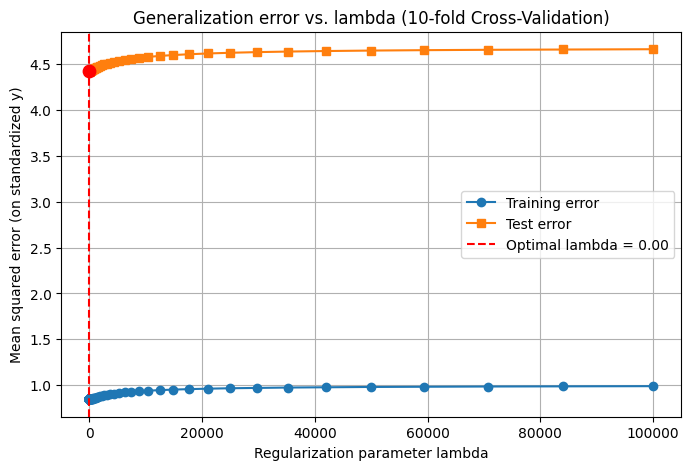

In [115]:

plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Test error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

As visible on the plot the linear regression model fails to capture the test data. There is a visible difference on the test and the training error. This indicates overfitting on the training set, as the model is not able to generalize the knowledge to the test set, this means that the parameters of the model are tuned to the data it was trained on. 


This is a logical result when we look deeper into the attributes: The mass is not in a linear relationship with the other attributes. As it is also stated in Kepler's laws (which can be used for planet mass estimation if there is a moon or a spacecraft in orbit of the planet): https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion the relationship between some of these attributes is already quadratic or third degree, additionally there is no clear equation that would describe the relationships between our input and target attributes.

At the same time it is also observable that regularization helps with limiting the generalization error. As we increase lambda, the generalization error drops, then starts increasing while the training error steadily increases as we include higher and higher lambdas. This is a direct consequence of how regularization is applied, as it "forces" the weights away from the overfitting solution. However, if the lambda parameter is too high, it prevents the model from capturing the data and the regularization penalty won't enable the model to fit the data.
[Formula for regularization]

In [116]:
ridge = Ridge(alpha=optimal_lambda)

X_train_scaled = (X_train_full - np.mean(X_train_full, axis=0)) / np.std(X_train_full, axis=0)
y_train_scaled = (y_train_full - np.mean(y_train_full)) / np.std(y_train_full)

X_test_scaled = (X_test_full - np.mean(X_train_full, axis=0)) / np.std(X_train_full, axis=0)
y_test_scaled = (y_test_full - np.mean(y_train_full)) / np.std(y_train_full)

ridge.fit(X_train_scaled, y_train_scaled)
coeffs = ridge.coef_
intercept = ridge.intercept_

y_pred_train = ridge.predict(X_train_scaled)
y_pred_test = ridge.predict(X_test_scaled)

train_error = mean_squared_error(y_train_scaled, y_pred_train)
test_error = mean_squared_error(y_test_scaled, y_pred_test)

coeffs, intercept, train_error, test_error

(array([-1.32415271e-02,  1.19637820e-01,  4.52354500e-05, -1.04365631e-01,
         4.79358643e-01]),
 np.float64(1.9005117198211835e-17),
 0.8434489244980431,
 0.2152830797073576)

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# 1. Create a pipeline
# This pipeline will first scale the data, then run the Ridge regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=optimal_lambda))
])

# 2. Fit the pipeline
# It automatically scales X_train_full and fits the ridge model
# (Note: We use the *full*, unscaled data here)
pipe.fit(X_train_full, y_train_full)

# 3. Make predictions
# It automatically scales X_test_full using the *training* stats
# and then predicts. The output is in the original y scale.
y_pred_test = pipe.predict(X_test_full)

# 4. Calculate meaningful error
test_error = mean_squared_error(y_test_full, y_pred_test)

test_error

1.7351363470919123e+56

In [61]:
#round coefficients for better visibility
coeffs = np.round(coeffs, 3)

# create a table from X_Columns and coeffs
coeffs_table = pd.DataFrame({'Feature': X_columns, 'Coefficient': coeffs})
coeffs_table

,Feature,Coefficient
0,distance,0.019
1,stellar_magnitude,0.025
2,orbital_radius,0.044
3,orbital_period,-0.016
4,eccentricity,-0.032
5,radius,0.296


Linear regression aims to fit a linear combination of the input features to capture the output feature: f(x,w) = w0 +
w1x1+· · ·+wMxM.
Now we go deeper into our optimal linear model by looking at the coefficients. These show how the individual attributes are weighted in the linear regression model.

As we see the last coefficient is the most significant, which corresponds to the last attribute in our training data. This coefficient is for the radius. This is in line with our previous analysis from the correlation matrix which also showed the strongest correlation between these 2 attributes. The other 5 coefficients are signifcantly smaller which is again in sync with the observations from our data analysis.
[correlation matrix comparison]

In [188]:
K1 = 5  # outer folds
K2 = 5  # inner folds

# Regularization and ANN hyperparameters
lambdas = np.logspace(-5, 5, 50)
hidden_units = [1, 8, 16, 32, 64, 128]

In [189]:
# Storage
test_errors_outer = {
    'baseline': np.zeros(K1),
    'ridge': np.zeros(K1),
    'ann': np.zeros(K1)
}

In [130]:
optimal_hs = np.zeros(K1)
optimal_lambdas = np.zeros(K1)

In [190]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PredictorANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(PredictorANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [250]:
class DeepANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(DeepANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [251]:
def train_custom_ann(X_train, y_train, X_val, y_val, hidden_units, 
                      lr=1e-3, weight_decay=0.0, epochs=200, batch_size=32, verbose=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert numpy arrays to torch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(device)

    # Datasets and loaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    model = DeepANN(X_train.shape[1], hidden_units).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    print(f'Validation Loss: {val_loss}')
    return val_loss, model


In [ ]:
train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=32, lr=1e-10, epochs=10)

Validation Loss: 6.2783637046813965


(6.2783637046813965,
 PredictorANN(
   (model): Sequential(
     (0): Linear(in_features=6, out_features=32, bias=True)
     (1): ReLU()
     (2): Linear(in_features=32, out_features=1, bias=True)
   )
 ))

In [252]:
# Outer cross-validation loop
from sklearn.neural_network import MLPRegressor


outer_cv = KFold(K1, shuffle=True)

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}/{K1}")

    X_train_outer, y_train_outer = X[outer_train_idx], y[outer_train_idx]
    X_test_outer, y_test_outer = X[outer_test_idx], y[outer_test_idx]

    # Standardize (based on training data)
    X_train_mean = np.mean(X_train_outer, axis=0)
    X_train_std = np.std(X_train_outer, axis=0)

    y_train_mean = np.mean(y_train_outer)
    y_train_std = np.std(y_train_outer)

    X_train_outer = (X_train_outer - X_train_mean) / X_train_std
    X_test_outer = (X_test_outer - X_train_mean) / X_train_std
    y_train_outer = (y_train_outer - y_train_mean) / y_train_std
    y_test_outer = (y_test_outer - y_train_mean) / y_train_std

    # BASELINE MODEL
    y_pred_baseline = np.full_like(y_test_outer, np.mean(y_train_outer))
    test_errors_outer['baseline'][outer_fold] = np.mean((y_test_outer - y_pred_baseline) ** 2)

    #INNER CV for Ridge
    inner_cv = KFold(K2, shuffle=True)
    ridge_val_errors = np.zeros(len(lambdas))

    for i, lam in enumerate(lambdas):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            model = Ridge(alpha=lam)
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            inner_errors.append(mean_squared_error(y_val_inner, y_val_pred))
        ridge_val_errors[i] = np.mean(inner_errors)

    optimal_lambda = lambdas[np.argmin(ridge_val_errors)]
    optimal_lambdas[outer_fold] = optimal_lambda

    # Train Ridge on full outer training set
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_test_error = np.mean((y_test_outer - ridge_model.predict(X_test_outer)) ** 2)
    test_errors_outer['ridge'][outer_fold] = ridge_test_error
    # INNER CV for ANN
    ann_val_errors = np.zeros(len(hidden_units))

    for j, h in enumerate(hidden_units):
        print(f"hidden unit: {h}")
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner,
                                            hidden_units=h, lr=1e-16, epochs=10)
            inner_errors.append(val_loss)
        ann_val_errors[j] = np.mean(inner_errors)

    optimal_h = hidden_units[np.argmin(ann_val_errors)]
    optimal_hs[outer_fold] = optimal_h

    # Train final ANN model on full outer training set
    _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer,
                                    hidden_units=optimal_h, lr=1e-16, epochs=10)
    ann_model.eval()

    device = next(ann_model.parameters()).device  # get model’s device
    X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_t = ann_model(X_test_t).cpu().numpy().flatten()

    ann_test_error = mean_squared_error(y_test_outer, y_pred_t)
    print(f"ANN test error: {ann_test_error}")
    test_errors_outer['ann'][outer_fold] = ann_test_error


# Results summary
print("\nMean test errors across outer folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")

Outer fold 1/5
hidden unit: 1
Validation Loss: 0.44315454363822937
Validation Loss: 1.1709097623825073
Validation Loss: 0.12866638600826263
Validation Loss: 4.324999809265137
Validation Loss: 0.5289130210876465
hidden unit: 8
Validation Loss: 4.216815948486328
Validation Loss: 0.16830909252166748
Validation Loss: 0.25400739908218384
Validation Loss: 0.41138631105422974
Validation Loss: 0.08739017695188522
hidden unit: 16
Validation Loss: 0.23609042167663574
Validation Loss: 0.22144556045532227
Validation Loss: 0.297905832529068
Validation Loss: 4.23317289352417
Validation Loss: 0.16664545238018036
hidden unit: 32
Validation Loss: 4.307493686676025
Validation Loss: 0.034842170774936676
Validation Loss: 0.3363153040409088
Validation Loss: 0.1750825196504593
Validation Loss: 0.26608070731163025
hidden unit: 64
Validation Loss: 0.21275679767131805
Validation Loss: 0.05338643863797188
Validation Loss: 0.3450445830821991
Validation Loss: 4.259563446044922
Validation Loss: 0.13509677350521088

In [249]:
# Summarize Results in Table
results_df = pd.DataFrame({
    'Fold': np.arange(1, K1 + 1),
    'lambda* (Ridge)': optimal_lambdas,
    'h* (ANN)': optimal_hs,
    'Baseline Test Error': test_errors_outer['baseline'],
    'Ridge Test Error': test_errors_outer['ridge'],
    'ANN Test Error': test_errors_outer['ann']
})

# Display the table
print("\n===== Table 1: Cross-Validation Results =====")
print(results_df.to_string(index=False))

# Summary statistics
print("\nMean ± Std of Test Errors across folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")


===== Table 1: Cross-Validation Results =====
 Fold  lambda* (Ridge)  h* (ANN)  Baseline Test Error  Ridge Test Error  ANN Test Error
    1      1644.676178      32.0             0.135353          0.128754        0.154959
    2      1534.368409      32.0             0.133316          0.128416        0.282290
    3        31.440355      32.0            18.274551         17.452386       21.785370
    4      1889.652340     128.0             0.206200          0.187551        0.276659
    5      1245.883364      64.0             0.281924          0.262600        0.448001

Mean ± Std of Test Errors across folds:
baseline  : 3.8063 ± 7.2343
ridge     : 3.6319 ± 6.9104
ann       : 4.5895 ± 8.5985


We ran 2 level cross validation over 3 configurations: A baseline model, calculating the mean ver each outer fold, linear regression, and a neural network. Our table shows that the results across the cross validation folds do not favor a clear approach. Additionally the baseline is only slightly surpassed by the linear regression, and the neural network is performing worse which suggests that a single layer neural network can't capture the training data. It is important to note that this is only basde on the cross-validation.